# Summer School on Data Science Tools and Techniques in Modelling Complex Networks
### [Przemysław Szufel](https://szufel.pl/en) and [Bogumił Kamiński](http://bogumilkaminski.pl/about/)
## Understanding SimpleHypergraphs.jl design principles
### Day 3, Wednesday, August 21th, 2019, 13:00 to 16:00: Part 1

In [1]:
using Pkg
Pkg.activate(".")
using SimpleHypergraphs

┌ Info: Recompiling stale cache file C:\Users\bogum\.julia\compiled\v1.1\SimpleHypergraphs\rB8ho.ji for SimpleHypergraphs [aa4a32ff-dd5d-5357-90e3-e7a9512f0501]
└ @ Base loading.jl:1184


### Matrices in Julia

In [2]:
m1 = rand(2,3)

2×3 Array{Float64,2}:
 0.190517  0.794416  0.225537
 0.679383  0.859335  0.867406

In [3]:
eltype(m1)

Float64

In [4]:
m2 = [(i,j) for i in 1:4, j in 1:3]

4×3 Array{Tuple{Int64,Int64},2}:
 (1, 1)  (1, 2)  (1, 3)
 (2, 1)  (2, 2)  (2, 3)
 (3, 1)  (3, 2)  (3, 3)
 (4, 1)  (4, 2)  (4, 3)

In [5]:
eltype(m2)

Tuple{Int64,Int64}

In [6]:
m2[1,1]

(1, 1)

In [7]:
m2[1:2, 1:2]

2×2 Array{Tuple{Int64,Int64},2}:
 (1, 1)  (1, 2)
 (2, 1)  (2, 2)

In [8]:
m3 = rand([1, nothing], 5, 4)

5×4 Array{Union{Nothing, Int64},2}:
 1          nothing   nothing   nothing
  nothing  1         1          nothing
 1          nothing   nothing  1       
 1          nothing   nothing  1       
 1          nothing   nothing   nothing

In [9]:
eltype(m3)

Union{Nothing, Int64}

In [10]:
m3[1,1] = 10

10

In [11]:
m3

5×4 Array{Union{Nothing, Int64},2}:
 10          nothing   nothing   nothing
   nothing  1         1          nothing
  1          nothing   nothing  1       
  1          nothing   nothing  1       
  1          nothing   nothing   nothing

In [12]:
m3[1,1] = nothing

In [13]:
m3

5×4 Array{Union{Nothing, Int64},2}:
  nothing   nothing   nothing   nothing
  nothing  1         1          nothing
 1          nothing   nothing  1       
 1          nothing   nothing  1       
 1          nothing   nothing   nothing

In [14]:
m3[1,1] = "some other type"

MethodError: MethodError: Cannot `convert` an object of type String to an object of type Int64
Closest candidates are:
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  convert(::Type{T<:Integer}, !Matched::Ptr) where T<:Integer at pointer.jl:23
  ...

In [15]:
m3

5×4 Array{Union{Nothing, Int64},2}:
  nothing   nothing   nothing   nothing
  nothing  1         1          nothing
 1          nothing   nothing  1       
 1          nothing   nothing  1       
 1          nothing   nothing   nothing

In [16]:
m3 .= 1

5×4 Array{Union{Nothing, Int64},2}:
 1  1  1  1
 1  1  1  1
 1  1  1  1
 1  1  1  1
 1  1  1  1

In [17]:
m3

5×4 Array{Union{Nothing, Int64},2}:
 1  1  1  1
 1  1  1  1
 1  1  1  1
 1  1  1  1
 1  1  1  1

In [18]:
m3[1:2, 1:2] .= nothing

2×2 view(::Array{Union{Nothing, Int64},2}, 1:2, 1:2) with eltype Union{Nothing, Int64}:
 nothing  nothing
 nothing  nothing

In [19]:
m3

5×4 Array{Union{Nothing, Int64},2}:
  nothing   nothing  1  1
  nothing   nothing  1  1
 1         1         1  1
 1         1         1  1
 1         1         1  1

### SimpleHypergraphs.jl design

This will be a classical hypergraph model we will want to work with (on the left).

Vertices are blue and edges are red.

On the right we have its representation as a bipartite graph.

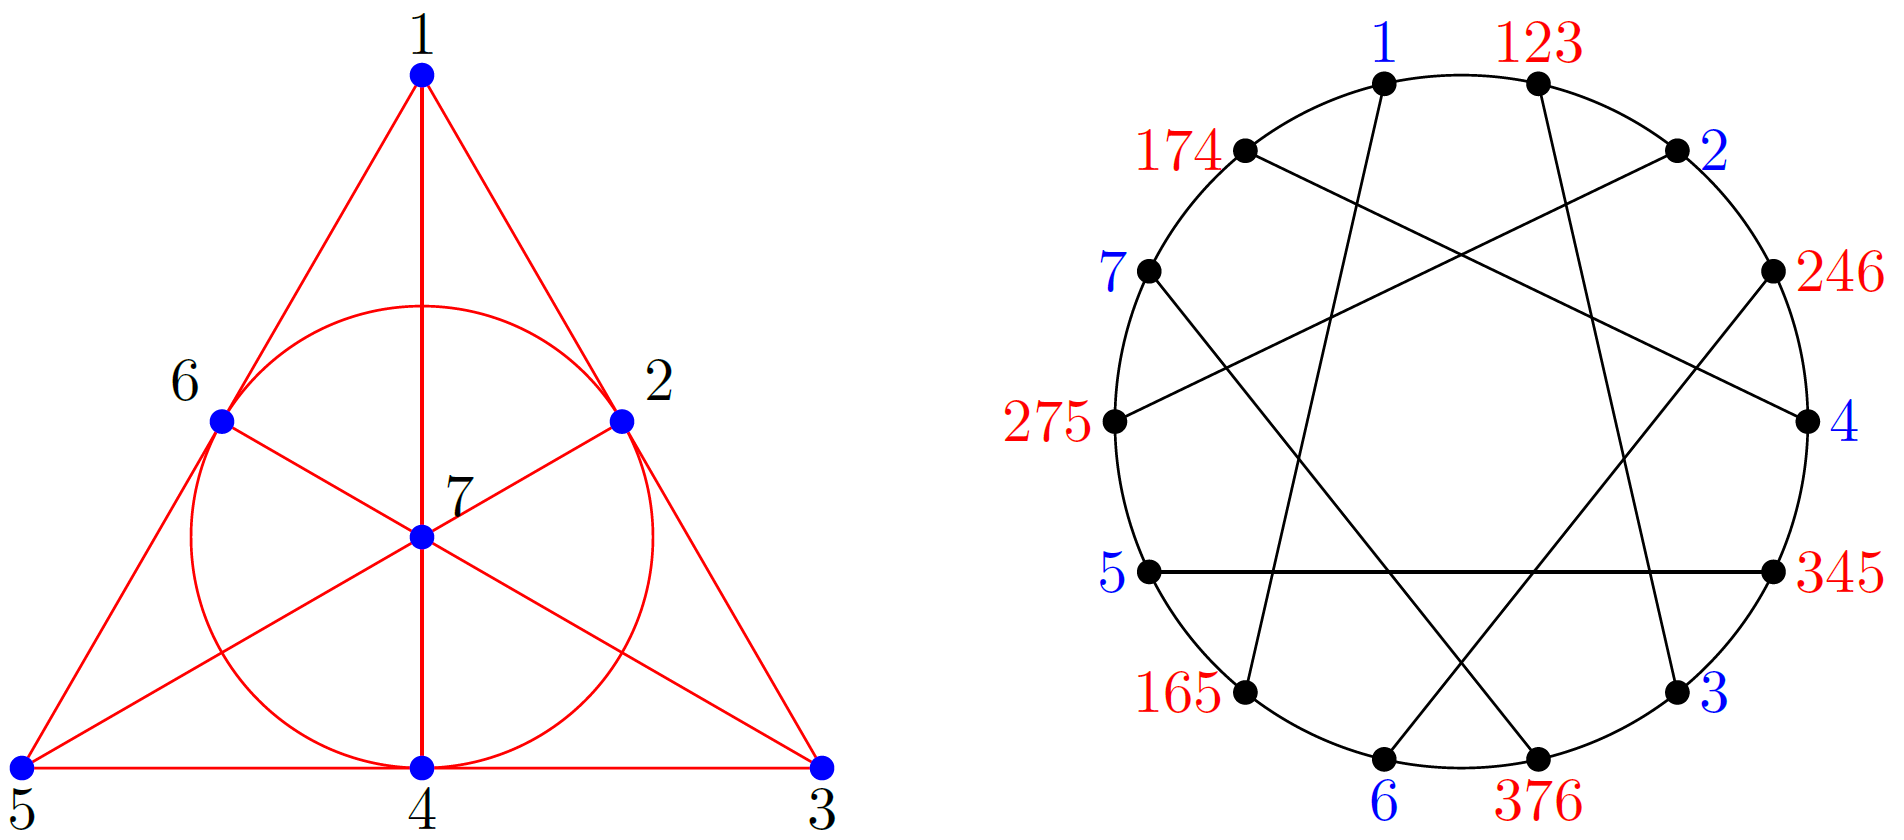

In [20]:
hyperedge_names = ["123", "147", "156", "246", "257", "345", "367"]

7-element Array{String,1}:
 "123"
 "147"
 "156"
 "246"
 "257"
 "345"
 "367"

What we expect from a hypergraph type?
1. get a list of vertices
2. get a list of edges
3. check if a vertex is contained in a given hyperedge
4. get a list of hyperedges that contain a given vertes
5. get a list of vertices that are contained in a given edge

**Requiements 1 and 2:**

If a hypergraph has $n$ vertices and $m$ hyperedges denote the set of vertices $V$ as $[n]=\{1,\dots,n\}$, and a set of hyperedges $He$ as $[m]$

**Requirement 3:**

Look at a hypergraph as an *incidence matrix* $M$, where $M[i,j]$
gives you an information about the status of a vertex $i$ in a hyperedge $j$.

A basic approach could be to make $M$ have `Bool` element type.

In [21]:
hg1 = Bool[1  1  1  0  0  0  0
           1  0  0  1  1  0  0
           1  0  0  0  0  1  1
           0  1  0  1  0  1  0
           0  0  1  0  1  1  0
           0  0  1  1  0  0  1
           0  1  0  0  1  0  1]

7×7 Array{Bool,2}:
  true   true   true  false  false  false  false
  true  false  false   true   true  false  false
  true  false  false  false  false   true   true
 false   true  false   true  false   true  false
 false  false   true  false   true   true  false
 false  false   true   true  false  false   true
 false   true  false  false   true  false   true

This does not work for weighted hypergraphs though.

A more universal approach is to make $M$ have an element type `Union{Nothing, <:Real}`.
In this case `nothing` will represent absence of a vertex in the edge.

As our graph is unweighted this would be:

In [22]:
hg2 = ifelse.(hg1 .== 0, nothing, 1)

7×7 Array{Union{Nothing, Int64},2}:
 1         1         1          nothing   nothing   nothing   nothing
 1          nothing   nothing  1         1          nothing   nothing
 1          nothing   nothing   nothing   nothing  1         1       
  nothing  1          nothing  1          nothing  1          nothing
  nothing   nothing  1          nothing  1         1          nothing
  nothing   nothing  1         1          nothing   nothing  1       
  nothing  1          nothing   nothing  1          nothing  1       

**Regiurements 4 and 5:**

We can filter rows or columns of the matrix to get what we want:

In [23]:
hyperedge_id = findall.(x-> !isnothing(x), eachrow(hg2))

7-element Array{Array{Int64,1},1}:
 [1, 2, 3]
 [1, 4, 5]
 [1, 6, 7]
 [2, 4, 6]
 [3, 5, 6]
 [3, 4, 7]
 [2, 5, 7]

In [24]:
getindex.(Ref(hyperedge_names), hyperedge_id)

7-element Array{Array{String,1},1}:
 ["123", "147", "156"]
 ["123", "246", "257"]
 ["123", "345", "367"]
 ["147", "246", "345"]
 ["156", "257", "345"]
 ["156", "246", "367"]
 ["147", "257", "367"]

In [25]:
[hyperedge_names findall.(x-> !isnothing(x), eachcol(hg2))]

7×2 Array{Any,2}:
 "123"  [1, 2, 3]
 "147"  [1, 4, 7]
 "156"  [1, 5, 6]
 "246"  [2, 4, 6]
 "257"  [2, 5, 7]
 "345"  [3, 4, 5]
 "367"  [3, 6, 7]

**Problems**

1. Typical hypergraphs are sparse. `Matrix` will use up too much memory in such cases.
2. Getting a list of vertices in a hyperedge and a list of edges that contain a vertex is $O(n)$ operation.

**Solution**

1. Keep two mappings as dictionaries
    * vertices $\to$ hyperedges
    * hyperedges $\to$ vertices
2. Make such a structure pretend to be an `AbstractMatrix`

In [26]:
@edit Hypergraph{Int}(2,3)

Final step: a complex data structure is easily corrupted. Let us write a function that makes a hypergraph consistency check.

In [27]:
using SimpleHypergraphs

In [28]:
hg3 = Hypergraph{Int, Nothing, String}(7, 7)

7×7 Hypergraph{Int64,Nothing,String}:
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing  nothing

In [29]:
hg3 .= hg2

7×7 Hypergraph{Int64,Nothing,String}:
 1         1         1          nothing   nothing   nothing   nothing
 1          nothing   nothing  1         1          nothing   nothing
 1          nothing   nothing   nothing   nothing  1         1       
  nothing  1          nothing  1          nothing  1          nothing
  nothing   nothing  1          nothing  1         1          nothing
  nothing   nothing  1         1          nothing   nothing  1       
  nothing  1          nothing   nothing  1          nothing  1       

In [30]:
b = BipartiteView(hg3)

{14, 21} undirected simple Int64 graph

In [31]:
using GraphPlot

┌ Info: Recompiling stale cache file C:\Users\bogum\.julia\compiled\v1.1\GraphPlot\bUwXr.ji for GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1184


In [32]:
using LightGraphs

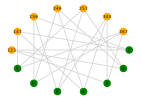

In [33]:
gplot(b, layout=circular_layout, nodelabel = [string.(1:7); hyperedge_names],
      nodefillc = [fill("green", 7); fill("orange", 7)])

In [34]:
function validate_hypergraph!(h::Hypergraph)
    for (v, s) in enumerate(h.v2he)
        for (he, w) in pairs(s)
            length(h.he2v) >= he || error("hyperedge $he not found")
            haskey(h.he2v[he], v) || error("hyperedge $he does not contain vertex $v")
            h.he2v[he][v] == w || error("weight $w does not match weight $(h.he2v[he][v])")
        end
    end
    for (he, s) in enumerate(h.he2v)
        for (v, w) in pairs(s)
            length(h.v2he) >= he || error("vertex $v not found")
            haskey(h.v2he[v], he) || error("vertex $v is not contained in hyperedge $he")
            h.v2he[v][he] == w || error("weight $w does not match weight $(h.v2he[v][he])")
        end
    end
    return nothing
end

validate_hypergraph! (generic function with 1 method)

In [35]:
validate_hypergraph!(hg3)

In [36]:
hg3.v2he[1][7] = 1

1

In [37]:
validate_hypergraph!(hg3)

ErrorException: hyperedge 7 does not contain vertex 1

In [38]:
hg3.he2v[7][1] = 10

10

In [39]:
validate_hypergraph!(hg3)

ErrorException: weight 1 does not match weight 10

In [40]:
hg3.he2v[7][1] = 1

1

In [41]:
validate_hypergraph!(hg3)